In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

## Data Preparation

In [2]:
data = pd.read_csv("Laporan Stock Gudang Darurat 27 April 2021-REV.xlsx - Keluar-Masuk.csv", skipinitialspace=True)

In [3]:
data.head()

,Tanggal,IN / OUT,Nomor GDN/GRN,Gudang,Dari/Kepada-Masking,Nama Barang,Merk/Jenis-Deleted,Satuan,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat
0,1-Feb-20,IN,1.01,G2,Gudang Regional PMI_Serang,Masker Bedah,Sensi,Pcs,"350,000",NaN,"Rp 7,000","Rp 2,450,000,000",0.006,2100.0
1,1-Feb-20,OUT,1.01,G2,Ketua Umum,Masker N95,3M,Pcs,NaN,800,"Rp 108,240","Rp 86,592,000",0.04,32.0
2,1-Feb-20,OUT,1.02,G2,PMI Kabupaten Natuna,Masker Bedah,Sensi,Pcs,NaN,"20,000","Rp 7,000","Rp 140,000,000",0.006,120.0
3,5-Feb-20,OUT,5.01,G2,Palang Merah Hongkong,Masker Bedah,Sensi,Pcs,NaN,"50,000","Rp 7,000","Rp 350,000,000",0.006,300.0
4,5-Feb-20,OUT,5.02,G2,Lain-lain,Masker Bedah,Sensi,Pcs,NaN,"4,000","Rp 7,000","Rp 28,000,000",0.006,24.0


In [4]:
data.columns

Index(['Tanggal', 'IN / OUT', 'Nomor GDN/GRN', 'Gudang', 'Dari/Kepada-Masking',
       'Nama Barang', 'Merk/Jenis-Deleted', 'Satuan', 'Masuk', 'Keluar',
       'Nilai', 'Jumlah', 'Berat', 'Total Berat'],
      dtype='object')

- Tanggal: Tanggal transaksi
- IN / OUT: Keterangan barang masuk atau keluar
- Nomor GDN/GRN: Nomor kode gudang(cek lagi)
- Gudang: Kode gudang setiap lokasi
- Dari/Kepada-Masking: donatur atau penerima manfaat, mengacu juga pada kolom 'IN / OUT'
- Nama Barang: jelas
- Merk/Jenis-Deleted: jelas
- Satuan: satuan untuk barang
- Masuk: Jumlah masuk bukan nominal dalam bentuk uang
- Keluar: Jumlah keluar bukan nominal dalam bentuk uang
- Nilai: Nominal uang untuk setiap barang
- Jumlah: Jumlah total nominal uang untuk setiap barang
- Berat: berat barang per satuan
- Total Berat: Jumlah barang per transaksi

## Check NaN

In [5]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Masuk,7377,0.900843
Merk/Jenis-Deleted,3857,0.470998
Keluar,816,0.099646
Nilai,517,0.063133
Jumlah,426,0.052021
Berat,95,0.011601
Satuan,2,0.000244
Nomor GDN/GRN,1,0.000122
Tanggal,0,0.000000
IN / OUT,0,0.000000


- Banyak data NaN dikarenakan ada korelasi antar kolom `IN / OUT`, `Masuk`, `Keluar`, sehingga menyebabkan data banyak NaN
- Untuk masalah data NaN pada kolom `Masuk`, `Keluar`, akan dilakukan imputasi dengan nilai `0` agar tidak ada data NaN
- Untuk kolom `Merk/Jenis-Deleted` di drop karena merupakan data yang kurang penting
- Untuk kolom `Nilai`, `Jumlah`, `Berat`, `Satuan`, `Nomor GDN/GRN`, hapus bagian rows nya yang menunjukkan nilai NaN

## Imputasi Data NaN

In [6]:
#Isi nilai '0' untuk kolom `Masuk` dan `Keluar`
data['Masuk'] = data['Masuk'].fillna(0)
data['Keluar'] = data['Keluar'].fillna(0)

In [7]:
#Drop kolom 'Merk/Jenis-Deleted'
data = data.drop(['Merk/Jenis-Deleted'], axis=1)

In [8]:
#Drop rows NaN
data = data.dropna()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7666 entries, 0 to 8188
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tanggal              7666 non-null   object 
 1   IN / OUT             7666 non-null   object 
 2   Nomor GDN/GRN        7666 non-null   object 
 3   Gudang               7666 non-null   object 
 4   Dari/Kepada-Masking  7666 non-null   object 
 5   Nama Barang          7666 non-null   object 
 6   Satuan               7666 non-null   object 
 7   Masuk                7666 non-null   object 
 8   Keluar               7666 non-null   object 
 9   Nilai                7666 non-null   object 
 10  Jumlah               7666 non-null   object 
 11  Berat                7666 non-null   object 
 12  Total Berat          7666 non-null   float64
dtypes: float64(1), object(12)
memory usage: 838.5+ KB


### Masih banyak kolom bertipe data object, untuk memudahkan analisis, ubah beberapa kolom ke tipe data number

### Convert Data Type

In [10]:
#Buat fungsi untuk merubah kurs dan merapihkan angka
#Convert Currency
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove Rp.
     - Remove commas
     - Convert to float type
    """
    new_val = str(val).replace(',','').replace('Rp', '').replace('-',str(np.nan))
    return float(new_val)

#Convert Value that contain comma
def convert_comma(val):
    """
    Convert the string number value to a float
     - Remove commas
     - Convert to float type
    """
    new_val = str(val).replace(',','').replace('-',str(np.nan))
    return float(new_val)

In [11]:
data['Nilai'] = data['Nilai'].apply(convert_currency)

In [12]:
data['Masuk'] = data['Masuk'].apply(convert_comma)

In [13]:
data['Keluar'] = data['Keluar'].apply(convert_comma)

In [14]:
data['Jumlah'] = data['Jumlah'].apply(convert_currency)

In [15]:
data['Berat'] = data['Berat'].apply(convert_comma)

In [16]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7666 entries, 0 to 8188
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Tanggal              7666 non-null   datetime64[ns]
 1   IN / OUT             7666 non-null   object        
 2   Nomor GDN/GRN        7666 non-null   object        
 3   Gudang               7666 non-null   object        
 4   Dari/Kepada-Masking  7666 non-null   object        
 5   Nama Barang          7666 non-null   object        
 6   Satuan               7666 non-null   object        
 7   Masuk                7666 non-null   float64       
 8   Keluar               7666 non-null   float64       
 9   Nilai                7666 non-null   float64       
 10  Jumlah               7662 non-null   float64       
 11  Berat                7666 non-null   float64       
 12  Total Berat          7666 non-null   float64       
dtypes: datetime64[ns](1), float64(6),

In [18]:
data.describe()

,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat
count,7666.000000,7.666000e+03,7.666000e+03,7.662000e+03,7666.000000,7666.000000
mean,1698.780851,1.606064e+03,5.317244e+05,3.928565e+07,3.185299,400.948766
std,17122.469479,2.120517e+04,5.462839e+06,1.828753e+08,10.173428,2099.926581
min,0.000000,0.000000e+00,4.160000e+02,1.364000e+03,0.006000,0.000000
25%,0.000000,3.000000e+00,7.000000e+03,3.500000e+05,0.040000,1.500000
50%,0.000000,2.000000e+01,3.600000e+04,1.500000e+06,0.150000,10.000000
75%,0.000000,1.397500e+02,2.200000e+05,7.500000e+06,1.200000,60.000000
max,512000.000000,1.347438e+06,1.124200e+08,6.531000e+09,65.000000,80846.280000


## Menambahkan Beberapa kolom untuk lebih memudahkan analisa dan melakukan visualisasi data

#### Kolom `Jenis Barang`
    - Pengelompokkan data ini dilakukan untuk memudahkan melihat distribusi dari jenis barang, karena jika dilihat dari nama barang, tidak akan efektif untuk di analisis

In [19]:
# buat kolom baru untuk jenis barang
data['Jenis Barang'] = data['Nama Barang']

# ubah string ke lower
data['Nama Barang'] = data['Nama Barang'].str.lower()

In [20]:
data.head()

,Tanggal,IN / OUT,Nomor GDN/GRN,Gudang,Dari/Kepada-Masking,Nama Barang,Satuan,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat,Jenis Barang
0,2020-02-01,IN,1.01,G2,Gudang Regional PMI_Serang,masker bedah,Pcs,350000.0,0.0,7000.0,2.450000e+09,0.006,2100.0,Masker Bedah
1,2020-02-01,OUT,1.01,G2,Ketua Umum,masker n95,Pcs,0.0,800.0,108240.0,8.659200e+07,0.040,32.0,Masker N95
2,2020-02-01,OUT,1.02,G2,PMI Kabupaten Natuna,masker bedah,Pcs,0.0,20000.0,7000.0,1.400000e+08,0.006,120.0,Masker Bedah
3,2020-02-05,OUT,5.01,G2,Palang Merah Hongkong,masker bedah,Pcs,0.0,50000.0,7000.0,3.500000e+08,0.006,300.0,Masker Bedah
4,2020-02-05,OUT,5.02,G2,Lain-lain,masker bedah,Pcs,0.0,4000.0,7000.0,2.800000e+07,0.006,24.0,Masker Bedah


In [21]:
#Check unique untuk melihat ada barang apa saja dan memudahkan dalam pengelompokkan jenis barang
print(data['Jenis Barang'].unique())

['Masker Bedah' 'Masker N95' 'Hazmat' 'Kacamata' 'Sepatu Boot' 'Virkon'
 'Disinfektan 5 Liter' 'Sarung Tangan Karet' 'Sprayer'
 'Hand Sanitizer Saku' 'Hand Sanitizer 500 ml' 'Hand Sanitizer 5 Liter'
 'Disinfektan 20 Liter' 'Masker Respirator' 'Sarung Tangan Latex'
 'Hand Sanitizer 1 Liter' 'Hand Sanitizer 20 Liter' 'Tandon Air 300 lt'
 'Kaporit' 'Jas Hujan ' 'Kompresor Set' 'Air Mineral Botol' 'Wipol'
 'Rompi PMI' 'Masker Kain' 'Sabun Lifebouy' 'Paper Bag PHBS' 'Paket PHBS'
 'Teh Celup Sariwangi' 'Mie Instan' 'My Baby Minyak Telon Plus'
 'Sabun Marina' 'Sabun Claudia' 'Obat - Bodrexin Batuk Pilek'
 'Obat - Bodrexin Flu PE' 'Obat - Vidoran Gummy Frugi E ND' 'Susu Vidoran'
 "Obat - Vidoran Smart Sberry 25's" 'Obat - Contrexyn Tablet'
 'Vitamin - IPI B Complex' 'Obat - Vidoran Gummy 54 gr'
 'Hemaviton Energy Drink' 'Obat - Oskadryl Extra Sirup' 'Hemaviton Jreng'
 'Obat - Bodrex Flu & Batuk 60ml' "Obat - Bodrex 20's"
 'Obat - Oskadon Extra' 'Obat - Oskadryl Extra Tablet'
 'Obat - Wybert He

In [22]:
# Buat lst untuk mengelompokkan nama barang berdasarkan jenis dan fungsinya
APD = ['masker', 'hazmat', 'sarung tangan', 'shoes', 'cap']
Makanan = ['mie','biskuit','jahe','koko','simba', 
           'khong','cracker', 'pie', 'choco',  'cerelac', 
           'wafer', 'beras', 'gula', 'minyak',  
           'makanan', 'roti', 'saos', 'kecap', 'sarden', 'malkies', 
           'cookies', 'momogi', 'snack', 'joss', 'bubur', 'assortment', 'food']
ObatSuplemen = ['obat', 'vitamin','hemaviton','bintang', ]
Bahan_kimia = ['virkon', 'disinfektan', 'sanitizer', 'wipol']
Alat = ['sprayer', 'terpal', 'kaporit', 'jas', 'kompresor', 'rompi', 'matras', 'ventilator']
Kebutuhan_MCK = ['hygiene', 'sabun', 'dovie', 'soap', 'pasta gigi', 'sikat gigi', 
                 'pembalut', 'shampo', 'detergen', 'tisu', 'sunlight', 'biosol']
Kebutuhan_Medis = ['hansaplast']
Minuman = ['susu','milk','air','buavita','nescafe','joss','jos','kopi','energen', 'teh',]
Paket_Bantuan = ['sembako', 'paket', 'family']
Peralatan_Penunjang_Medis = ['kacamata', 'sepatu', 'apron', 'termometer', 'alat rapid test', 
                             'usg', 'selang', 'spray', 'sarung', 'tikar ', 'selimut', 'jerigen','life', 
                             'knapsack', 'mayat', 'shield']
Lainnya = ['tripod','banner','baliho','leaflet','buku','paket karyawan pmi','panduan','paper', 'pisau', 
           'poster', 'pamflet', 'stiker', 'boneka', 'steps', 'boat','dayung', 'helm','river','wastafel', 
           'hit', 'samsung', 'boat']
Pakaian = ['tshirt', 't-shirt', 'clothes', 'shirt', 'underware', 'sandal','handuk','sejadah','bantal',
           'sprei','mukena','pakaian','kemeja', 'form', 'popok', 'bayi']

# Ubah nama sesuai jenis barang yang sudah di kelompokkan
data.loc[data['Nama Barang'].str.contains('|'.join(APD)), 'Jenis Barang'] = 'APD'
data.loc[data['Nama Barang'].str.contains('|'.join(Makanan)), 'Jenis Barang'] = 'Makanan'
data.loc[data['Nama Barang'].str.contains('|'.join(ObatSuplemen)), 'Jenis Barang'] = 'Obat&Suplemen'
data.loc[data['Nama Barang'].str.contains('|'.join(Bahan_kimia)), 'Jenis Barang'] = 'Bahan Kimia'
data.loc[data['Nama Barang'].str.contains('|'.join(Alat)), 'Jenis Barang'] = 'Alat'
data.loc[data['Nama Barang'].str.contains('|'.join(Kebutuhan_MCK)), 'Jenis Barang'] = 'Kebutuhan MCK'
data.loc[data['Nama Barang'].str.contains('|'.join(Kebutuhan_Medis)), 'Jenis Barang'] = 'Kebutuhan Medis'
data.loc[data['Nama Barang'].str.contains('|'.join(Minuman)), 'Jenis Barang'] = 'Minuman'
data.loc[data['Nama Barang'].str.contains('|'.join(Paket_Bantuan)), 'Jenis Barang'] = 'Paket Bantuan'
data.loc[data['Nama Barang'].str.contains('|'.join(Peralatan_Penunjang_Medis)), 'Jenis Barang'] = 'Peralatan Penunjang Medis'
data.loc[data['Nama Barang'].str.contains('|'.join(Lainnya)), 'Jenis Barang'] = 'Lainnya'
data.loc[data['Nama Barang'].str.contains('|'.join(Pakaian)), 'Jenis Barang'] = 'Pakaian'

In [ ]:
def classify(item):
    if (item["negative_keywords"]) != "[]":
        return "negative"
    if len(item["positive_keywords"]) != "[]":
        return "positive"
    if len(item["neutral_keywords"]) != "[]":
        return "neutral"
    return 0  # what if none are true? or if multiple are true?

df["keyword_category"] = df.apply(classify, axis=1)

In [23]:
#Check unique
print(data['Jenis Barang'].unique())

['APD' 'Peralatan Penunjang Medis' 'Bahan Kimia' 'Minuman' 'Alat'
 'Lainnya' 'Paket Bantuan' 'Makanan' 'Kebutuhan MCK' 'Obat&Suplemen'
 'Kebutuhan Medis' 'Pakaian']


#### Kolom `Lokasi`
    - Hal ini dilakukan agar dapat melihat lokasi dari distribusi barang, dan untuk memudahkan dalam menampilkan peta distribusi pada tableau

In [24]:
# Manipulasi data untuk memudahkan
data['Dari/Kepada-Masking'] = data['Dari/Kepada-Masking'].replace(r"_", " ", regex=True).str.lower()

In [25]:
#Buat dulu kolom baru untuk Lokasi
data['Lokasi'] = data['Dari/Kepada-Masking']

In [26]:
# import list nama kota from another csv file
# data nama kota diambil dari https://simplemaps.com/data/id-cities
list_kota = pd.read_csv('Indonesian_cities_database.csv')

#Ubah menjadi list
kota = list_kota['city'].tolist()

#Tentukan Patternnya
pat = '|'.join(r"\b{}\b".format(x) for x in kota)

#Apply ke dataframe
data['Lokasi'] = data['Dari/Kepada-Masking'].str.extract('(' + pat + ')', flags=re.I)

In [27]:
# Fill null data with 'Not Known'
data['Lokasi'] = data['Lokasi'].fillna("Not Known")

In [28]:
data.head()

,Tanggal,IN / OUT,Nomor GDN/GRN,Gudang,Dari/Kepada-Masking,Nama Barang,Satuan,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat,Jenis Barang,Lokasi
0,2020-02-01,IN,1.01,G2,gudang regional pmi serang,masker bedah,Pcs,350000.0,0.0,7000.0,2.450000e+09,0.006,2100.0,APD,gudang
1,2020-02-01,OUT,1.01,G2,ketua umum,masker n95,Pcs,0.0,800.0,108240.0,8.659200e+07,0.040,32.0,APD,Not Known
2,2020-02-01,OUT,1.02,G2,pmi kabupaten natuna,masker bedah,Pcs,0.0,20000.0,7000.0,1.400000e+08,0.006,120.0,APD,kabupaten natuna
3,2020-02-05,OUT,5.01,G2,palang merah hongkong,masker bedah,Pcs,0.0,50000.0,7000.0,3.500000e+08,0.006,300.0,APD,Not Known
4,2020-02-05,OUT,5.02,G2,lain-lain,masker bedah,Pcs,0.0,4000.0,7000.0,2.800000e+07,0.006,24.0,APD,Not Known


#### Kolom `Jumlah Distribusi`
    - Hal ini dilakukan agar dapat melihat jumlah total distribusi dan memudahkan untuk visualisasi data

In [29]:
#Buat kolom baru untuk jumlah distribusi
data['Jumlah Distribusi'] = data['Masuk'] + data['Keluar']

### Save Data

In [30]:
#Simpan data yang telah di bersihkan ke dalam csv dan xlsx untuk di analisis lebih lanjut di tableau
new_data = data.copy()
new_data.to_csv('Laporan Stock Gudang PMI - NEW.csv', index=False)
new_data.to_excel('Laporan Stock Gudang PMI - NEW.xlsx', index=False)

- Sampai disini data sudah dibersihkan dan siap untuk dilakukan visualisasi untuk di analisis lebih lanjut
- `new_data` berisi semua kolom yang sudah dibersihkan

---

# Visualisasi Data

#### Melakukan EDA sederhana sebelum di analisis lebih lanjut lewat tableau
    - Hal ini dilakukan untuk melihat apakah data yang sudah bersih, sudah cukup untuk membuat dashboard di tableau dan sesuai dengan tujuan MVP yang sudah ditentukan sebelumnya

In [31]:
#Baca data yang sudah bersih
df = pd.read_csv('Laporan Stock Gudang PMI - NEW.csv')

In [32]:
df.head()

,Tanggal,IN / OUT,Nomor GDN/GRN,Gudang,Dari/Kepada-Masking,Nama Barang,Satuan,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat,Jenis Barang,Lokasi,Jumlah Distribusi
0,2020-02-01,IN,1.01,G2,gudang regional pmi serang,masker bedah,Pcs,350000.0,0.0,7000.0,2.450000e+09,0.006,2100.0,APD,gudang,350000.0
1,2020-02-01,OUT,1.01,G2,ketua umum,masker n95,Pcs,0.0,800.0,108240.0,8.659200e+07,0.040,32.0,APD,Not Known,800.0
2,2020-02-01,OUT,1.02,G2,pmi kabupaten natuna,masker bedah,Pcs,0.0,20000.0,7000.0,1.400000e+08,0.006,120.0,APD,kabupaten natuna,20000.0
3,2020-02-05,OUT,5.01,G2,palang merah hongkong,masker bedah,Pcs,0.0,50000.0,7000.0,3.500000e+08,0.006,300.0,APD,Not Known,50000.0
4,2020-02-05,OUT,5.02,G2,lain-lain,masker bedah,Pcs,0.0,4000.0,7000.0,2.800000e+07,0.006,24.0,APD,Not Known,4000.0


In [33]:
#Pisahkan data barang yang masuk dan keluar
df_in = df[df['IN / OUT'] == 'IN']
df_out = df[df['IN / OUT'] == 'OUT']

#Buat dataframe yang telah di grouping berdasarkan jenis barang
df_grp_in = df.groupby(['Jenis Barang']).sum().reset_index()

In [34]:
df_grp_in.head()

,Jenis Barang,Masuk,Keluar,Nilai,Jumlah,Berat,Total Berat,Jumlah Distribusi
0,APD,6257445.0,5607313.0,1.472085e+08,1.162454e+11,71.904,169368.99,11864758.0
1,Alat,5263.0,3933.0,2.701830e+09,1.313292e+10,13106.095,95396.91,9196.0
2,Bahan Kimia,850289.0,840641.0,5.669760e+08,4.116306e+10,4816.740,1203235.98,1690930.0
3,Kebutuhan MCK,1626088.0,1619453.0,1.922807e+07,1.054339e+10,594.314,264129.47,3245541.0
4,Kebutuhan Medis,2500.0,2500.0,1.260000e+06,1.500000e+08,0.840,100.00,5000.0


### Cek untuk korelasi datanya

<AxesSubplot:>

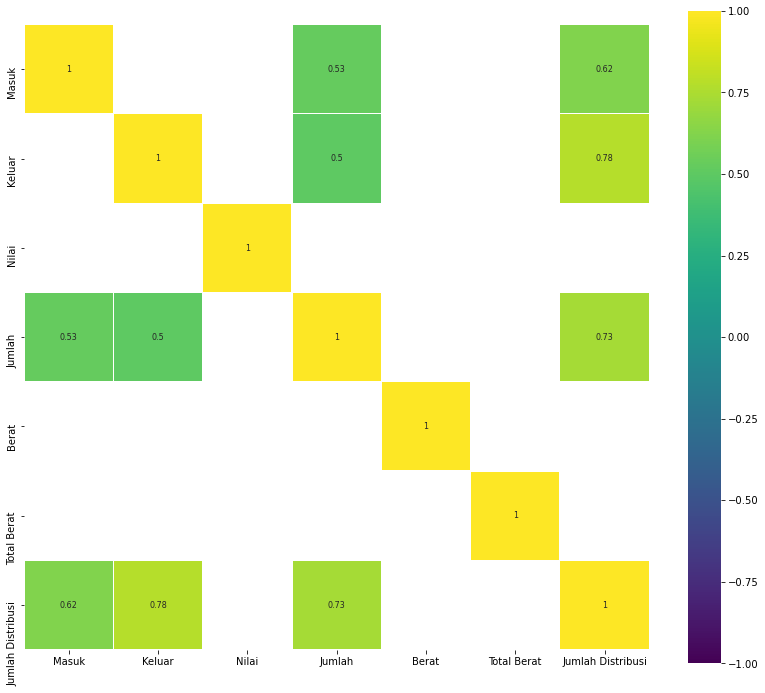

In [35]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corrmat[(corrmat >= 0.5) | (corrmat <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

- Melihat dari korelasi tersebut bisa dikatakan sudah cukup efektif jika melihat dari distribusi barang masuk dan keluar

### Lihat data menggunakan barplot untuk melihat jenis barang masuk dan keluar

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'APD'),
  Text(1, 0, 'Alat'),
  Text(2, 0, 'Bahan Kimia'),
  Text(3, 0, 'Kebutuhan MCK'),
  Text(4, 0, 'Kebutuhan Medis'),
  Text(5, 0, 'Lainnya'),
  Text(6, 0, 'Makanan'),
  Text(7, 0, 'Minuman'),
  Text(8, 0, 'Obat&Suplemen'),
  Text(9, 0, 'Pakaian'),
  Text(10, 0, 'Paket Bantuan'),
  Text(11, 0, 'Peralatan Penunjang Medis')])

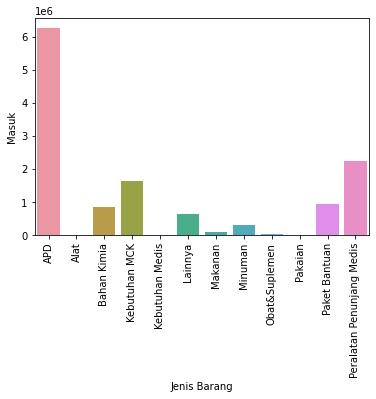

In [36]:
#cek berapa banyak barang masuk berdasarkan jenis barang
sns.barplot(x='Jenis Barang',
                 y='Masuk', data=df_grp_in)
plt.xticks(rotation=90)

- Dari data tersebut, terlihat bahwa tiga jenis barang yang paling banyak masuk adalah `APD`, `Peralatan Penunjang Medis`, `Kebutuhan MCK` 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'APD'),
  Text(1, 0, 'Alat'),
  Text(2, 0, 'Bahan Kimia'),
  Text(3, 0, 'Kebutuhan MCK'),
  Text(4, 0, 'Kebutuhan Medis'),
  Text(5, 0, 'Lainnya'),
  Text(6, 0, 'Makanan'),
  Text(7, 0, 'Minuman'),
  Text(8, 0, 'Obat&Suplemen'),
  Text(9, 0, 'Pakaian'),
  Text(10, 0, 'Paket Bantuan'),
  Text(11, 0, 'Peralatan Penunjang Medis')])

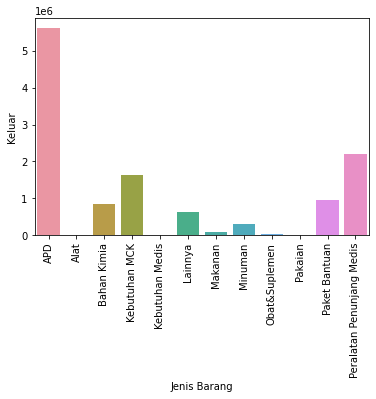

In [37]:
#cek berapa banyak barang keluar berdasarkan jenis barang
sns.barplot(x='Jenis Barang',
                 y='Keluar', data=df_grp_in)
plt.xticks(rotation=90)

- Sama seperti banyak nya barang masuk, terlihat bahwa tiga jenis barang yang paling banyak masuk adalah `APD`, `Peralatan Penunjang Medis`, `Kebutuhan MCK` 

<AxesSubplot:ylabel='Gudang'>

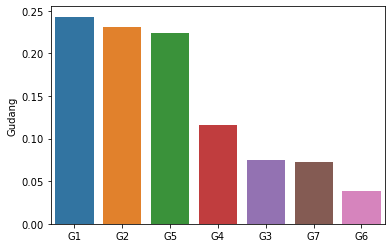

In [38]:
#cek untuk banyaknya aktivitas penerimaan donasi setiap gudang
sns.barplot(x=df_in['Gudang'].value_counts().index,
                 y=df_in['Gudang'].value_counts(normalize=True))

In [39]:
# Cek jumlahnya
df_in['Gudang'].value_counts()

G1    163
G2    155
G5    150
G4     78
G3     50
G7     49
G6     26
Name: Gudang, dtype: int64

<AxesSubplot:ylabel='Gudang'>

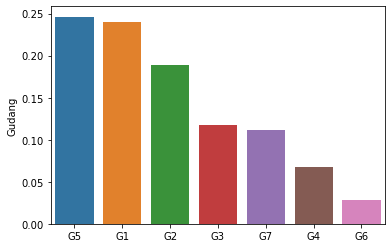

In [40]:
#cek untuk banyaknya aktivitas penerimaan donasi setiap gudang
sns.barplot(x=df_out['Gudang'].value_counts().index,
                 y=df_out['Gudang'].value_counts(normalize=True))

In [41]:
# Cek jumlahnya
df_out['Gudang'].value_counts()

G5    1723
G1    1679
G2    1322
G3     822
G7     782
G4     469
G6     198
Name: Gudang, dtype: int64

- Gudang G1, G2, G5 terlihat gudang yang paling banyak aktifitas penerimaan dan pendistribusian barang dibanding gudang yang lain
- Apakah ini sudah cukup efektif?
- Hal ini perlu ditelusuri fungsi dari masing-masing setiap gudang, untuk membantu efektifitas penerimaan dan pendistribusian barang

### Lihat distribusi barang masuk dan keluar berdasarkan jenis barang dan gudang

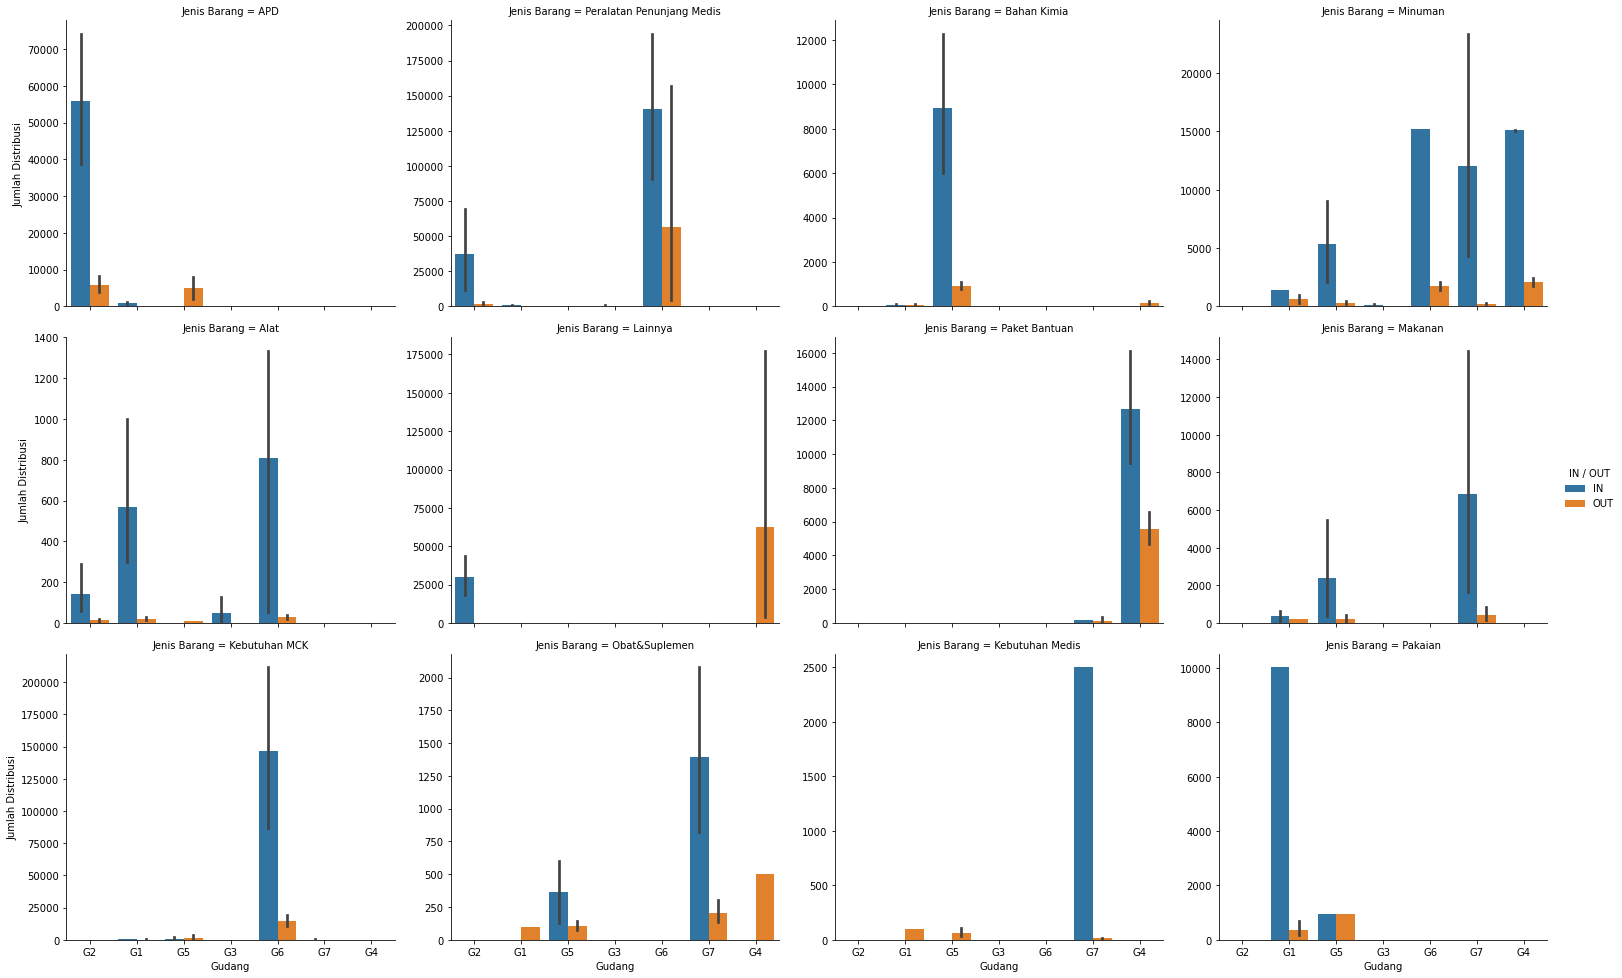

In [42]:
ax = sns.catplot(data=df, kind='bar', x='Gudang', y='Jumlah Distribusi', col='Jenis Barang', hue='IN / OUT',col_wrap=4, height=4.5,aspect=1.2, sharey=False)

- Dapat dilihat setiap gudang menerima atau menampung barang donasi yang berbeda, berikut data untuk setiap gudang:
    - Gudang G1 untuk barang masuk di dominasi oleh jenis barang: Alat, Pakaian, Minuman
    - Gudang G2: APD, Alat, Peralatan Penunjang Medis, Lainnya
    - Gudang G3: Alat
    - Gudang G4: Minuman, Paket Bantuan
    - Gudang G5: Obat & Suplemen, Bahan Kimia, Pakaian, Makanan, Minuman
    - Gudang G6: Alat, Peralatan Penunjang Medis, Kebutuhan MCK, Minuman
- Jika melihat dari data tersebut, tidak semua jenis barang masuk merata ke gudang-gudang PMI
- Apakah setiap gudang mempunyai fungsi yang berbeda?
- Hal ini harus ditelusuri lebih dalam agar dapat dilihat efektifitas dari setiap gudang

### Lihat data time series untuk barang masuk dan keluar setiap jenis barang

In [43]:
#Buat copy dataframe untuk set index ke tanggal
df_t = df.copy()

#set index ke tanggal
df_t.set_index('Tanggal', inplace=True)

#Pisahkan data barang masuk dan keluar
df_t_in = df_t[df_t['IN / OUT'] == 'IN']
df_t_out = df_t[df_t['IN / OUT'] == 'OUT']

### Lihat jumlah barang masuk dan keluar
    - Jumlah barang masuk semua gudang

Text(0.5, 1.0, 'Jumlah Barang Masuk')

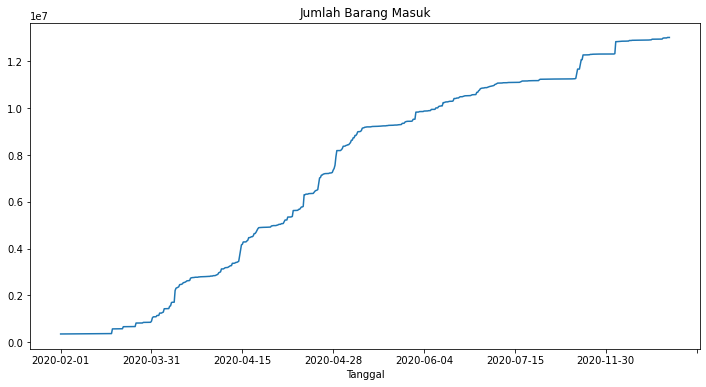

In [44]:
#plot untuk distribusi keluar jenis barang APD
df_t[(df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(figsize=(12,6))
plt.title('Jumlah Barang Masuk')

    - Jumlah barang keluar semua gudang

Text(0.5, 1.0, 'Jumlah Barang Keluar')

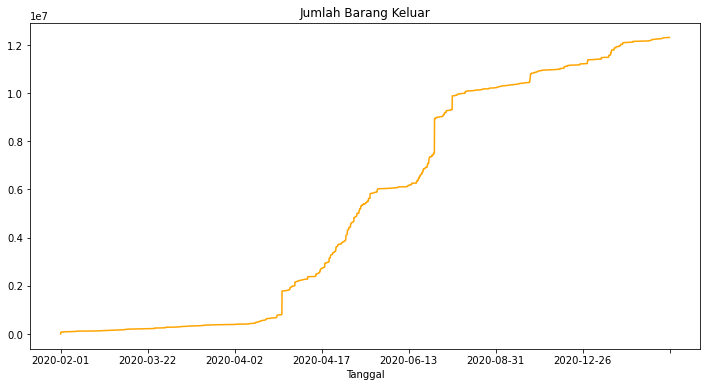

In [45]:
#plot untuk distribusi keluar jenis barang APD
df_t[(df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(figsize=(12,6), color='orange')
plt.title('Jumlah Barang Keluar')

    - Jumlah Barang Masuk di Setiap Gudang

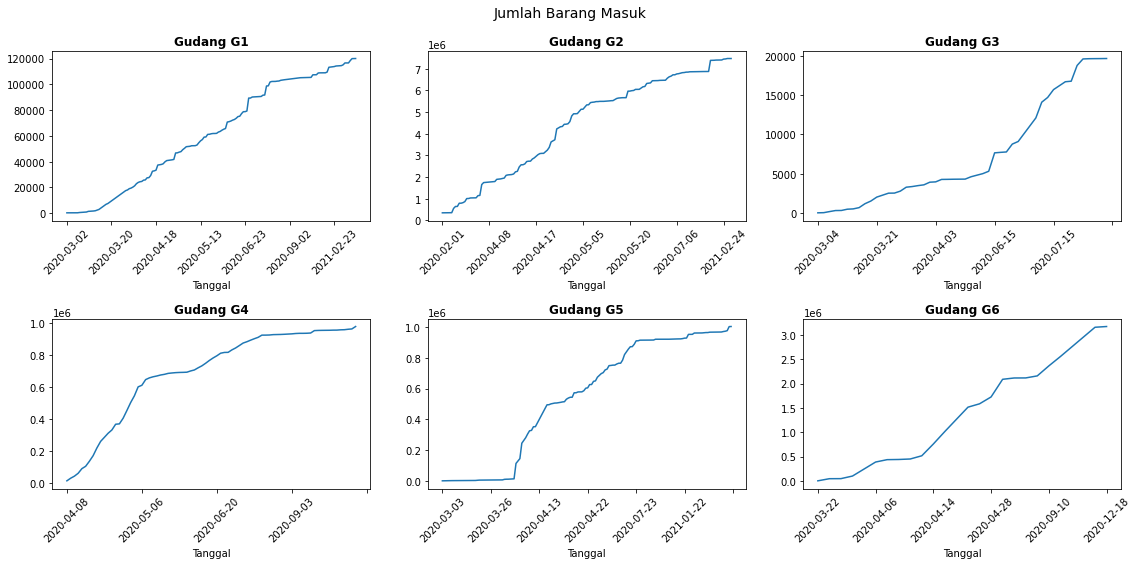

In [46]:
# create the time series subplots
fig,ax =  plt.subplots( 2, 3, figsize = ( 16, 8))

df_t[(df_t['Gudang'] == 'G1') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G1',ax = ax[0][0])
ax[0][0].tick_params(axis='x', labelrotation = 45)
ax[0][0].set_title('Gudang G1', fontweight='bold')

df_t[(df_t['Gudang'] == 'G2') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G2',ax = ax[0][1])
ax[0][1].tick_params(axis='x', labelrotation = 45)
ax[0][1].set_title('Gudang G2', fontweight='bold')

df_t[(df_t['Gudang'] == 'G3') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G3', ax = ax[0][2])
ax[0][2].tick_params(axis='x', labelrotation = 45)
ax[0][2].set_title('Gudang G3', fontweight='bold')

df_t[(df_t['Gudang'] == 'G4') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G4', ax = ax[1][0])
ax[1][0].tick_params(axis='x', labelrotation = 45)
ax[1][0].set_title('Gudang G4', fontweight='bold')

df_t[(df_t['Gudang'] == 'G5') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G5', ax = ax[1][1])
ax[1][1].tick_params(axis='x', labelrotation = 45)
ax[1][1].set_title('Gudang G5', fontweight='bold')

df_t[(df_t['Gudang'] == 'G6') & (df_t['IN / OUT'] == 'IN')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G6', ax = ax[1][2])
ax[1][2].tick_params(axis='x', labelrotation = 45)
ax[1][2].set_title('Gudang G6', fontweight='bold')

fig.suptitle('Jumlah Barang Masuk', fontsize=14)
fig.tight_layout(pad = 1.3)

    - Jumlah Barang Keluar di Setiap Gudang

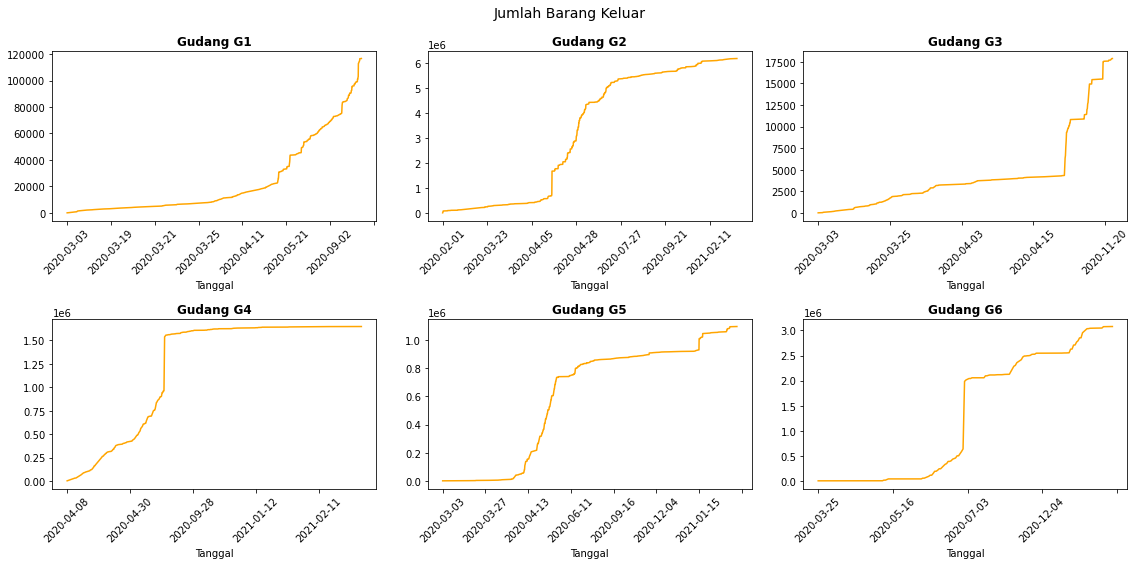

In [48]:
# create the time series subplots
fig,ax =  plt.subplots( 2, 3, figsize = ( 16, 8))

df_t[(df_t['Gudang'] == 'G1') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G1',ax = ax[0][0], color='orange')
ax[0][0].tick_params(axis='x', labelrotation = 45)
ax[0][0].set_title('Gudang G1', fontweight='bold')

df_t[(df_t['Gudang'] == 'G2') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G2',ax = ax[0][1], color='orange')
ax[0][1].tick_params(axis='x', labelrotation = 45)
ax[0][1].set_title('Gudang G2', fontweight='bold')

df_t[(df_t['Gudang'] == 'G3') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G3', ax = ax[0][2], color='orange')
ax[0][2].tick_params(axis='x', labelrotation = 45)
ax[0][2].set_title('Gudang G3', fontweight='bold')

df_t[(df_t['Gudang'] == 'G4') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G4', ax = ax[1][0], color='orange')
ax[1][0].tick_params(axis='x', labelrotation = 45)
ax[1][0].set_title('Gudang G4', fontweight='bold')

df_t[(df_t['Gudang'] == 'G5') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G5', ax = ax[1][1], color='orange')
ax[1][1].tick_params(axis='x', labelrotation = 45)
ax[1][1].set_title('Gudang G5', fontweight='bold')

df_t[(df_t['Gudang'] == 'G6') & (df_t['IN / OUT'] == 'OUT')]['Jumlah Distribusi'].sort_index().cumsum().plot(label='G6', ax = ax[1][2], color='orange')
ax[1][2].tick_params(axis='x', labelrotation = 45)
ax[1][2].set_title('Gudang G6', fontweight='bold')

fig.suptitle('Jumlah Barang Keluar', fontsize=14)
fig.tight_layout(pad = 1.3)